In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from datetime import datetime

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' 

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore') 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [18]:
# 导入预测者网数据并做筛选
df = pd.read_csv('./all_stock_data_monthly/stock_data.csv', encoding='gbk')
df = df[['交易日期','股票代码','涨跌幅','流通市值','总市值','交易天数','是否交易','是否涨停','是否跌停','市净率']]
df['交易日期'] = pd.to_datetime(df['交易日期'],format='%Y-%m-%d')
df = df[df['交易日期'] > pd.to_datetime('2006-01-01')]
# 注意！！！要shift一步，因为我们这月底的调仓考察收益的是下一个月回报率！！！
df.sort_values(by=['股票代码','交易日期'], inplace=True)
# df['下月回报率'] = df['涨跌幅'].shift(-1)
# 这样直接移动的后果是每个股票最后一个交易日的“下月回报率”是错误的，清理起来很麻烦
df['下月回报率'] = df.groupby('股票代码')['涨跌幅'].shift(-1) # 每组内运用shift
df.head()

,交易日期,股票代码,涨跌幅,流通市值,总市值,交易天数,是否交易,是否涨停,是否跌停,市净率,下月回报率
74,2006-01-25,sh600000,0.155898,1.014300e+10,4.412205e+10,16.0,1.0,0.0,0.0,2.978765,0.081631
75,2006-02-24,sh600000,0.081631,1.097100e+10,4.772385e+10,14.0,1.0,0.0,0.0,3.221925,-0.109107
76,2006-03-20,sh600000,-0.109107,9.774000e+09,4.251690e+10,8.0,1.0,0.0,0.0,2.738443,0.209055
77,2006-05-31,sh600000,0.209055,1.166490e+10,3.903255e+10,13.0,1.0,0.0,0.0,3.278472,-0.006018
78,2006-06-30,sh600000,-0.006018,1.159470e+10,3.879765e+10,21.0,1.0,0.0,0.0,3.258741,-0.112007


In [20]:
#无奈之举，如果这个月的下个月都没有交易，那shift来的“下月收益率”显然就不能使用
df['delta'] = df['交易日期'].diff().shift(-1).apply(lambda x: x.days)
df['delta'] = df['delta'].dropna()
df = df[df['delta'] <= 32]
df.head()



,交易日期,股票代码,涨跌幅,流通市值,总市值,交易天数,是否交易,是否涨停,是否跌停,市净率,下月回报率,delta
74,2006-01-25,sh600000,0.155898,1.014300e+10,4.412205e+10,16.0,1.0,0.0,0.0,2.978765,0.081631,30.0
75,2006-02-24,sh600000,0.081631,1.097100e+10,4.772385e+10,14.0,1.0,0.0,0.0,3.221925,-0.109107,24.0
76,2006-03-20,sh600000,-0.109107,9.774000e+09,4.251690e+10,8.0,1.0,0.0,0.0,2.738443,0.209055,72.0
77,2006-05-31,sh600000,0.209055,1.166490e+10,3.903255e+10,13.0,1.0,0.0,0.0,3.278472,-0.006018,30.0
78,2006-06-30,sh600000,-0.006018,1.159470e+10,3.879765e+10,21.0,1.0,0.0,0.0,3.258741,-0.112007,31.0


In [21]:
df.tail()

,交易日期,股票代码,涨跌幅,流通市值,总市值,交易天数,是否交易,是否涨停,是否跌停,市净率,下月回报率,delta
592054,2021-07-12,sz301020,1.493421,9.210000e+08,3.884000e+09,5.0,1.0,0.0,0.0,NaN,NaN,0.0
592055,2021-07-12,sz301021,4.179704,1.589000e+09,7.431000e+09,5.0,1.0,0.0,0.0,NaN,NaN,0.0
592056,2021-07-12,sz301022,0.298235,6.710000e+08,2.683000e+09,7.0,1.0,0.0,0.0,NaN,NaN,0.0
592057,2021-07-12,sz301023,0.387069,7.550000e+08,3.020000e+09,4.0,1.0,0.0,0.0,NaN,NaN,0.0
592058,2021-07-12,sz301039,1.004310,2.406000e+09,2.814600e+10,3.0,1.0,0.0,0.0,NaN,NaN,NaN


In [5]:
from datetime import datetime
from datetime import timedelta
datetime(2020, 3, 31)-datetime(2020,2,28) > timedelta(33)

False

In [5]:
# 导入预测者网数据并做筛选
df = pd.read_csv('./all_stock_data_monthly/stock_data.csv', encoding='gbk')
df = df[['交易日期','股票代码','涨跌幅','流通市值','总市值','交易天数','是否交易','是否涨停','是否跌停','市净率']]
df['交易日期'] = pd.to_datetime(df['交易日期'],format='%Y-%m-%d')
df = df[df['交易日期'] > pd.to_datetime('2006-01-01')]
df = df.sort_values(by=['交易日期','股票代码'])
df = df[df['是否交易'] != 0] # 剔除月末停牌股票，万科在2015年12月18日停牌，2016年7月4日复牌，12月31日那天不能买入
df = df[df['交易天数'] >= 10] # 去除交易时间过段的股票，可能*ST或新股
df = df[df['是否涨停'] == 0] # 去除月末涨跌停的股票
df = df[df['是否跌停'] == 0]
df.set_index('交易日期', inplace=True)
df['股票代码'] = df['股票代码'].str[2:]
# 只取开头为000,60,002，不要300创业板，68科创板还有B股
df = df[df['股票代码'].str.startswith('00') | df['股票代码'].str.startswith('60')] # | 代表或，& 代表和，~ 代表取反
df

,股票代码,涨跌幅,流通市值,总市值,交易天数,是否交易,是否涨停,是否跌停,市净率
交易日期,,,,,,,,,
2006-01-20,600001,0.235485,2.942275e+09,8.667473e+09,13.0,1.0,0.0,0.0,1.011501
2006-01-20,600010,0.248870,2.926685e+09,7.894685e+09,13.0,1.0,0.0,0.0,1.240180
2006-01-20,600012,0.036665,1.555000e+09,7.250032e+09,13.0,1.0,0.0,0.0,2.347039
2006-01-20,600037,0.166333,3.614844e+09,1.054270e+10,13.0,1.0,0.0,0.0,4.725135
2006-01-20,600059,0.194355,8.113014e+08,1.773936e+09,13.0,1.0,0.0,0.0,1.512539
...,...,...,...,...,...,...,...,...,...
2021-06-30,003040,-0.193916,2.383000e+09,1.401900e+10,21.0,1.0,0.0,0.0,NaN
2021-06-30,003041,-0.072131,7.080000e+08,2.830000e+09,21.0,1.0,0.0,0.0,NaN
2021-06-30,003042,-0.121259,7.720000e+08,3.090000e+09,21.0,1.0,0.0,0.0,NaN


In [7]:
zhongzheng500 = pd.read_csv('./all_stock_data_monthly/index data/sz399905.csv',encoding='gbk')
zhongzheng500.set_index('交易日期',inplace=True)
zhongzheng500 = zhongzheng500[['涨跌幅']]
zhongzheng500 = zhongzheng500.rename(columns={'涨跌幅':'中证500涨跌幅'})
hushen300 = pd.read_csv('./all_stock_data_monthly/index data/sh000300.csv',encoding='gbk')
hushen300.set_index('交易日期',inplace=True)
hushen300 = hushen300[['涨跌幅']]
hushen300 = hushen300.rename(columns={'涨跌幅':'沪深300涨跌幅'})
shangzheng50 = pd.read_csv('./all_stock_data_monthly/index data/sh000016.csv',encoding='gbk')
shangzheng50.set_index('交易日期',inplace=True)
shangzheng50 = shangzheng50[['涨跌幅']]
shangzheng50 = shangzheng50.rename(columns={'涨跌幅':'上证50涨跌幅'})

benchmark = pd.concat([zhongzheng500,hushen300,shangzheng50],join='outer',axis=1)
benchmark.sort_index(inplace=True)
benchmark =benchmark.loc['2006-01-01':,:]
benchmark.head(20)

,中证500涨跌幅,沪深300涨跌幅,上证50涨跌幅
2006-01-25,NaN,0.093287,0.063527
2006-02-28,NaN,0.043000,0.054210
2006-03-31,NaN,0.007671,-0.016282
2006-04-28,NaN,0.104854,0.098000
2006-05-31,NaN,0.164716,0.118635
2006-06-30,NaN,0.020881,0.022091
2006-07-31,NaN,-0.071476,-0.074504
2006-08-31,NaN,0.034277,0.027472
2006-09-29,NaN,0.048234,0.064031
2006-10-31,NaN,0.043618,0.070022


In [31]:
import numpy as np
index_list = pd.to_datetime(benchmark.index.tolist())
all_list = df.index.tolist()
nums = [i for i in all_list if i not in index_list]
nums = list(set(nums))
nums.sort()
nums[:5]

[Timestamp('2006-01-20 00:00:00'),
 Timestamp('2006-01-23 00:00:00'),
 Timestamp('2006-01-24 00:00:00'),
 Timestamp('2006-02-17 00:00:00'),
 Timestamp('2006-02-20 00:00:00')]

In [29]:
index_list[:5]

['2006-01-25', '2006-02-28', '2006-03-31', '2006-04-28', '2006-05-31']

In [38]:
# 导入预测者网数据并做筛选
df = pd.read_csv('./all_stock_data_monthly/stock_data.csv', encoding='gbk')
df = df[['交易日期','股票代码','涨跌幅','流通市值','总市值','交易天数','是否交易','是否涨停','是否跌停','市净率']]
df['交易日期'] = pd.to_datetime(df['交易日期'],format='%Y-%m-%d')
df = df[df['交易日期'] > pd.to_datetime('2006-01-01')]
# 注意！！！要shift一步，因为我们这月底的调仓考察收益的是下一个月回报率！！！
df.sort_values(by=['股票代码','交易日期'], inplace=True)
# df['下月回报率'] = df['涨跌幅'].shift(-1)
# 这样直接移动的后果是每个股票最后一个交易日的“下月回报率”是错误的，清理起来很麻烦
df['下月回报率'] = df.groupby('股票代码')['涨跌幅'].shift(-1) # 每组内运用shift

from datetime import timedelta
for i in range(5):
    if df.iloc[i+1]['交易日期'] - df.iloc[i]['交易日期'] > timedelta(33):
        df.drop(df.index[i],inplace=True)
df

,交易日期,股票代码,涨跌幅,流通市值,总市值,交易天数,是否交易,是否涨停,是否跌停,市净率,下月回报率
74,2006-01-25,sh600000,0.155898,1.014300e+10,4.412205e+10,16.0,1.0,0.0,0.0,2.978765,0.081631
75,2006-02-24,sh600000,0.081631,1.097100e+10,4.772385e+10,14.0,1.0,0.0,0.0,3.221925,-0.109107
77,2006-05-31,sh600000,0.209055,1.166490e+10,3.903255e+10,13.0,1.0,0.0,0.0,3.278472,-0.006018
78,2006-06-30,sh600000,-0.006018,1.159470e+10,3.879765e+10,21.0,1.0,0.0,0.0,3.258741,-0.112007
79,2006-07-31,sh600000,-0.112007,1.029600e+10,3.445200e+10,21.0,1.0,0.0,0.0,2.893739,0.117045
...,...,...,...,...,...,...,...,...,...,...,...
592054,2021-07-12,sz301020,1.493421,9.210000e+08,3.884000e+09,5.0,1.0,0.0,0.0,NaN,NaN
592055,2021-07-12,sz301021,4.179704,1.589000e+09,7.431000e+09,5.0,1.0,0.0,0.0,NaN,NaN
592056,2021-07-12,sz301022,0.298235,6.710000e+08,2.683000e+09,7.0,1.0,0.0,0.0,NaN,NaN
592057,2021-07-12,sz301023,0.387069,7.550000e+08,3.020000e+09,4.0,1.0,0.0,0.0,NaN,NaN


In [2]:
# 市值划分
bec = pd.read_csv('./processed_data/processed_stock_data_monthly.csv', encoding='gbk')
bec['股票代码'] = bec['股票代码'].map(lambda x: '%06d'%x)
bec['rank'] = bec.groupby('交易日期')['总市值'].rank(pct=True)
mkt_group = pd.DataFrame()
for i in range(10):
    sub_group = bec[(bec['rank'] <= 0.1*(i+1)) & (bec['rank'] > 0.1*i)] #用这些%、|符号记得加括号
    mkt_group['group%s'%(i+1)] = sub_group.groupby('交易日期')['下月回报率'].mean()
mkt_group.to_csv('./result/group_by_size.csv', encoding='gbk', index=True)

In [3]:
mkt_group

,group1,group2,group3,group4,group5,group6,group7,group8,group9,group10
交易日期,,,,,,,,,,
2006-01-25,0.047114,0.027784,0.024296,0.062503,0.053785,0.031248,0.027012,0.021551,0.046205,0.053089
2006-02-28,-0.040738,-0.004183,-0.000129,-0.007280,0.000426,-0.002916,0.029127,0.019678,0.045803,0.023322
2006-03-31,-0.050457,-0.020270,0.066790,0.075046,0.084879,0.096638,0.096789,0.121510,0.108600,0.129060
2006-04-28,0.338878,0.318564,0.298241,0.282544,0.265757,0.262844,0.232417,0.221649,0.202787,0.155962
2006-05-31,0.067830,0.086118,0.071426,0.079103,0.063442,0.063351,0.049356,0.049182,0.024978,0.025614
...,...,...,...,...,...,...,...,...,...,...
2021-01-29,0.067349,0.050308,0.053723,0.044395,0.050582,0.037548,0.042099,0.034319,0.012900,-0.003739
2021-02-26,0.067222,0.060983,0.052363,0.038559,0.046354,0.037403,0.035547,0.012932,0.005280,-0.035018
2021-03-31,0.011490,-0.000390,-0.002958,0.001897,0.006385,0.002969,0.002726,0.020839,0.015427,0.015303


<AxesSubplot:xlabel='交易日期'>

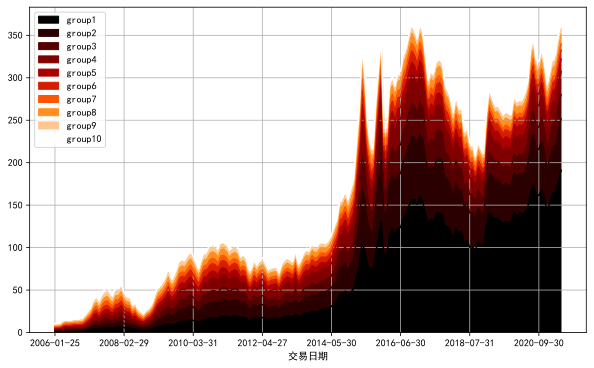

In [4]:
(1+mkt_group).cumprod().plot(kind='area', grid=True, colormap='gist_heat',figsize=(10,6), legend=True)


<AxesSubplot:>

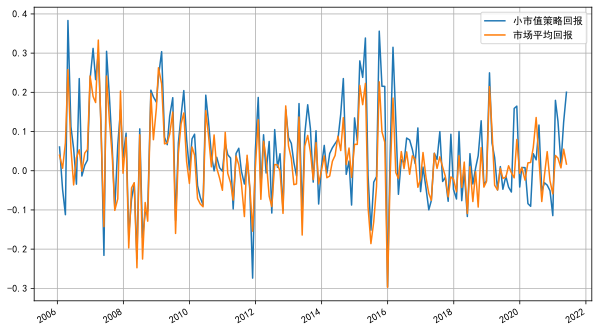

In [5]:
benchmark = pd.read_csv('./result/size_factor.csv', encoding='gbk',index_col=0, parse_dates=True)
fig, ax = plt.subplots(1,1,figsize=(10,6))
benchmark[['小市值策略回报','市场平均回报']].plot(ax=ax, grid=True, legend=True) 

In [6]:
benchmark

,小市值策略回报,市场平均回报,下月中证500回报,下月沪深300回报,下月上证50回报,小市值策略所选股票
2006-01-25,0.060567,0.039571,0.000000,0.043000,0.054210,600065|600340|600532|600562|600566|600766|6008...
2006-02-28,-0.048156,0.006364,0.000000,0.007671,-0.016282,600137|600234|600286|600691|600762|600847|6008...
2006-03-31,-0.112006,0.070904,0.000000,0.104854,0.098000,600137|600234|600286|600629|600691|600745|6007...
2006-04-28,0.383063,0.257872,0.000000,0.164716,0.118635,600137|600234|600385|600681|600691|600721|6007...
2006-05-31,0.112699,0.058020,0.000000,0.020881,0.022091,600137|600234|600691|600711|600745|600892|0000...
...,...,...,...,...,...,...
2021-01-29,0.179499,0.038939,0.002869,-0.002840,0.011744,600091|600112|600146|600247|600385|600687|6007...
2021-02-26,0.126323,0.032153,-0.017328,-0.054040,-0.057891,600086|600112|600146|600385|603996|000835|0020...
2021-03-31,0.017802,0.007369,0.037038,0.014882,-0.013613,600091|600112|600146|600385|000662|000835|0020...
2021-04-30,0.124495,0.054923,0.037510,0.040613,0.045552,600091|600146|600385|600599|600766|603996|0008...


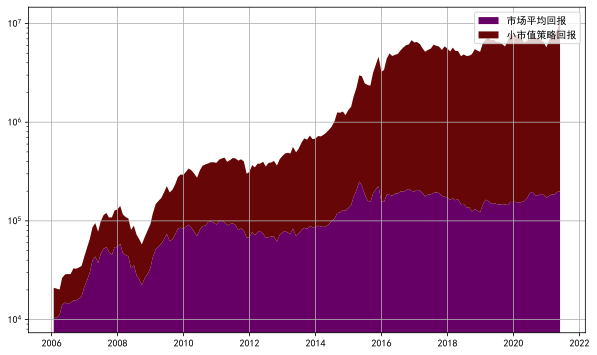

In [32]:
# 起始10000元的累计收益面积图
initial = 10000
strategy_cumulative_return = np.cumprod(1+benchmark['小市值策略回报'])
market_cumulative_return = np.cumprod(1+benchmark['市场平均回报'])
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.stackplot(benchmark.index, initial*market_cumulative_return, initial*strategy_cumulative_return,colors=['#660066','#660606'], labels=['市场平均回报','小市值策略回报'])
plt.grid(True)
plt.legend(loc='best')
ax.set_yscale('log')
plt.savefig('./figures/figure1_1.png', dpi=1000)

<AxesSubplot:>

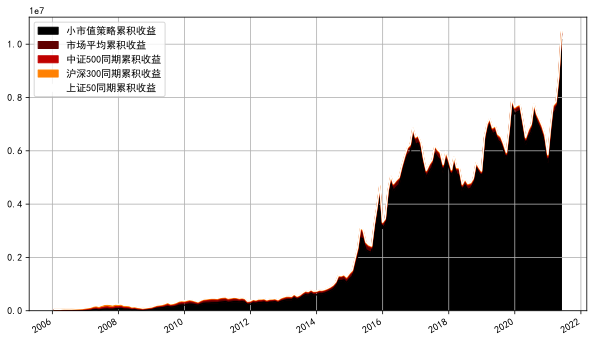

In [34]:
initial = 10000
new_df = pd.DataFrame()
new_df['小市值策略累积收益'] = initial*np.cumprod(1+benchmark['小市值策略回报'])
new_df['市场平均累积收益'] = initial*np.cumprod(1+benchmark['市场平均回报'])
new_df['中证500同期累积收益'] = initial*np.cumprod(1+benchmark['下月中证500回报'])
new_df['沪深300同期累积收益'] = initial*np.cumprod(1+benchmark['下月沪深300回报'])
new_df['上证50同期累积收益'] = initial*np.cumprod(1+benchmark['下月上证50回报']) #上证50都是大市值股票，尤其拿来做对比
fig, ax = plt.subplots(1,1,figsize=(10,6))
new_df.plot(ax=ax, kind='area',colormap='gist_heat',grid=True, label=True)

In [22]:
new_df

,小市值策略累积收益,市场平均累积收益,中证500同期累积收益,沪深300同期累积收益,上证50同期累积收益
2006-01-25,1.060567e+04,10395.713802,10000.000000,10430.000000,10542.100000
2006-02-28,1.009495e+04,10461.869506,10000.000000,10510.008530,10370.453528
2006-03-31,8.964249e+03,11203.658943,10000.000000,11612.024964,11386.757974
2006-04-28,1.239812e+04,14092.763659,10000.000000,13524.711268,12737.626006
2006-05-31,1.379537e+04,14910.430654,10000.000000,13807.120764,13019.012902
...,...,...,...,...,...
2021-01-29,6.568745e+06,179026.048938,32037.247049,52860.377125,44355.466262
2021-02-26,7.398530e+06,184782.269884,31482.105632,50003.802345,41787.683965
2021-03-31,7.530242e+06,186143.906527,32648.139860,50747.958932,41218.828223
2021-04-30,8.467719e+06,196367.440036,33872.771586,52808.985788,43096.428286
